In [8]:
from torchsummary                    import summary
from datetime                        import datetime
from src.data.to_tensor              import ToTensor
from src.data.mrw_dataset            import MRWDataset
from src.data.create_data_loaders    import create_data_loaders
from src.nn.archs                    import CNN_ALL
from src.nn.training.utils           import Trainer
from src.nn.losses.weighted_mse_loss import WeightedMSELoss
from src.nn.results.utils            import plot_losses

import random
import torch
import torch.nn           as nn
import numpy              as np
import src.ctes.str_ctes  as sctes
import src.ctes.num_ctes  as nctes
import src.ctes.path_ctes as pctes

In [9]:
builder = CNN_ALL
labels  = [sctes.C1, sctes.C2, sctes.L, sctes.EPSILON]

In [10]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device ' + str(device))

Using device cuda


In [12]:
sample_size = nctes.LEN_SAMPLE
dropout_probs=[0.7, 0.7, 0.7, 0.7, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.7, 0.7]
model = builder(input_size=sample_size, dropout_probs=dropout_probs)
model.to(device=device)

summary(model, (1, sample_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 32767]          --
|    └─Conv1d: 2-1                       [-1, 128, 32767]          256
|    └─BatchNorm1d: 2-2                  [-1, 128, 32767]          256
|    └─ReLU: 2-3                         [-1, 128, 32767]          --
├─AvgPool1d: 1-2                         [-1, 128, 8192]           --
├─Sequential: 1-3                        [-1, 64, 8189]            --
|    └─Conv1d: 2-4                       [-1, 64, 8189]            32,768
|    └─BatchNorm1d: 2-5                  [-1, 64, 8189]            128
|    └─ReLU: 2-6                         [-1, 64, 8189]            --
├─AvgPool1d: 1-4                         [-1, 64, 2048]            --
├─Sequential: 1-5                        [-1, 32, 2041]            --
|    └─Conv1d: 2-7                       [-1, 32, 2041]            16,384
|    └─BatchNorm1d: 2-8                  [-1, 32, 2041]            64
|   

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 32767]          --
|    └─Conv1d: 2-1                       [-1, 128, 32767]          256
|    └─BatchNorm1d: 2-2                  [-1, 128, 32767]          256
|    └─ReLU: 2-3                         [-1, 128, 32767]          --
├─AvgPool1d: 1-2                         [-1, 128, 8192]           --
├─Sequential: 1-3                        [-1, 64, 8189]            --
|    └─Conv1d: 2-4                       [-1, 64, 8189]            32,768
|    └─BatchNorm1d: 2-5                  [-1, 64, 8189]            128
|    └─ReLU: 2-6                         [-1, 64, 8189]            --
├─AvgPool1d: 1-4                         [-1, 64, 2048]            --
├─Sequential: 1-5                        [-1, 32, 2041]            --
|    └─Conv1d: 2-7                       [-1, 32, 2041]            16,384
|    └─BatchNorm1d: 2-8                  [-1, 32, 2041]            64
|   

In [13]:
data_path = pctes.DATAPATH
transform = ToTensor()

data = MRWDataset(data_path, transform, sample_size, labels)

In [14]:
batch_size = 6
valid_size = 0.2
test_size = 0.2

train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, test_size, data)

In [15]:
#weights = torch.tensor(1.5, 1.5, 1.0, 1.0])
#criterion = WeightedMSELoss(weights)
criterion = nn.MSELoss()
print(criterion)

MSELoss()


In [16]:
model_name = "Top-Down v1" # name given to the trained model

In [17]:
params = model.parameters()
lr = 0.001
weight_decay = 1e-5 # for L2 regularization (remove the line and the argument in optimizer if L2 reg not needed)

optimizer = torch.optim.Adam(params, lr, weight_decay = weight_decay)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)


In [18]:
n_epochs = 2

In [19]:
timestamp = datetime.now().strftime('%Y_%m_%d__%H_%M_%S')
arch_name  = builder.__name__
hyperparams_path = f"../../../data/hyperparams_{arch_name}_{timestamp}.npz"
model_path = f"../../../data/model_{arch_name}_{timestamp}.pt"
losses_path = f"../../../data/losses_{arch_name}_{timestamp}.npz"

In [20]:
print(timestamp)
print(arch_name)

2024_02_02__12_36_07
CNN_ALL


In [21]:
np.savez(hyperparams_path, 
         len           = len(data), 
         test_size     = test_size, 
         valid_size    = valid_size, 
         epochs        = n_epochs, 
         batch_size    = batch_size, 
         criterion     = str(criterion), 
         optimizer     = str(optimizer), 
         lr            = lr,
         seed          = seed,
         weight_decay  = weight_decay, 
         dropout_probs = dropout_probs, 
         model_name    = model_name,
         arch_name     = arch_name,
         labels        = labels)

In [22]:
train_losses, valid_losses = Trainer.train(n_epochs, train_loader, valid_loader, model, criterion, optimizer, device, model_path, losses_path)

Epoch 1/100 ...
Training ...


100%|██████████| 1366/1366 [01:16<00:00, 17.75it/s]


Validating ...


100%|██████████| 342/342 [00:04<00:00, 74.46it/s]


Epoch: 1 	training Loss: 0.095446 	validation Loss: 0.086061
Validation loss decreased (inf --> 0.086061).  Saving model ...
Epoch 2/100 ...
Training ...


 45%|████▍     | 611/1366 [00:27<00:34, 21.93it/s]

In [ ]:
# np.savez(losses_path , train=np.array(train_losses), val=np.array(valid_losses))

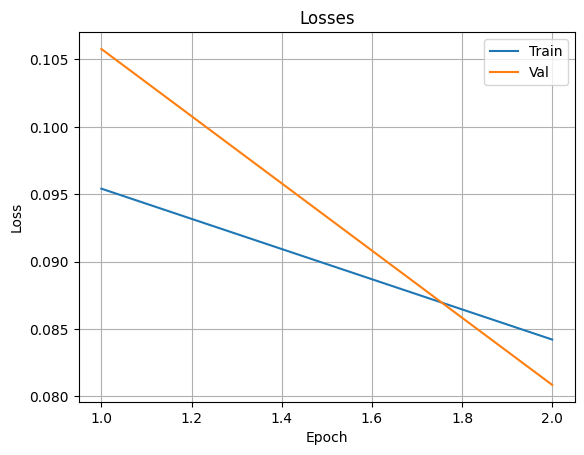

In [ ]:
plot_losses(len(train_losses), [train_losses, valid_losses], ["Train", "Val"])